### Initial

In [135]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

pd.set_option("mode.copy_on_write", True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


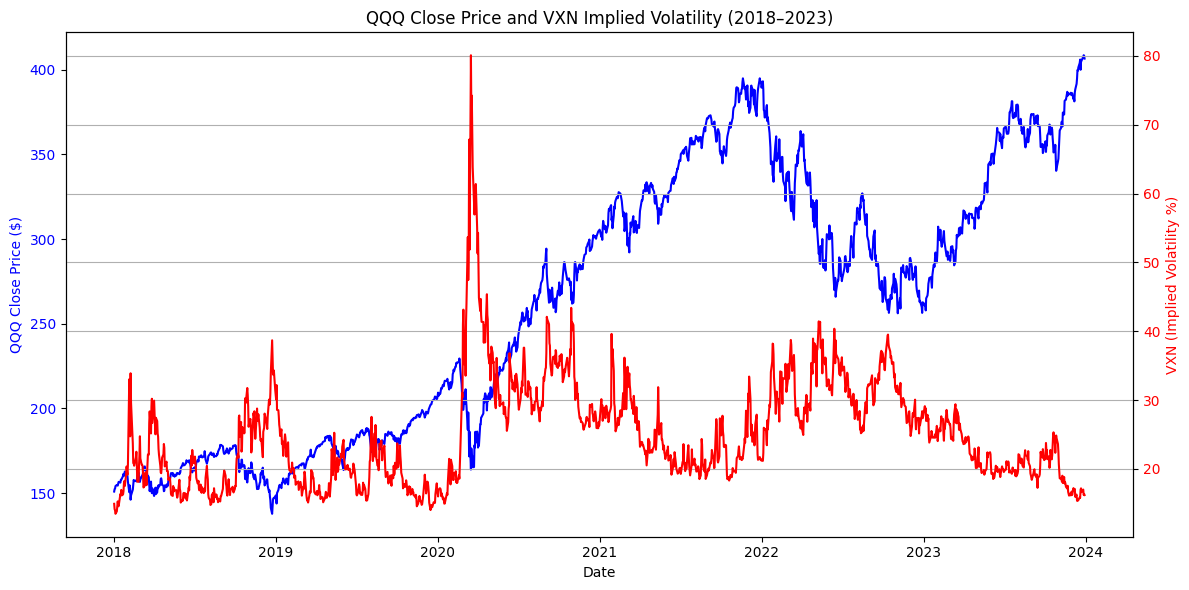

In [136]:
# Step 1: Download QQQ and VXN
qqq_daily = yf.download('QQQ', start='2018-01-01', end='2023-12-31', interval='1d')
vxn_daily = yf.download('^VXN', start='2018-01-01', end='2023-12-31', interval='1d')

# Step 2: Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot QQQ Close Price
ax1.plot(qqq_daily.index, qqq_daily['Close'], color='blue', label='QQQ Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('QQQ Close Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(vxn_daily.index, vxn_daily['Close'], color='red', label='VXN (Implied Volatility)')
ax2.set_ylabel('VXN (Implied Volatility %)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('QQQ Close Price and VXN Implied Volatility (2018–2023)')
fig.tight_layout()
plt.grid(True)
plt.show()


In [137]:
options_data = pd.read_csv("Data/qqq_option_data_2018_2023.csv")
# Clean up columns
options_data = options_data.rename(columns={
    'exdate': 'expiration',
    'cp_flag': 'type',   # 'C' or 'P'
    'strike_price': 'strike',
    'delta': 'delta_option',
    'gamma': 'gamma_option'
})
# Fix strike price
options_data['strike'] = options_data['strike'] / 1000  # If strike was stored as *1000
# Make sure date fields are datetime
options_data['date'] = pd.to_datetime(options_data['date'])
options_data['expiration'] = pd.to_datetime(options_data['expiration'])
options_data = options_data.drop(columns=['optionid', 'secid'])

options_data.head(5)

,date,expiration,type,strike,delta_option,gamma_option,impl_volatility,best_bid,best_offer,volume,open_interest
0,2018-01-02,2018-02-02,C,148.5,0.892498,0.021384,0.186879,10.49,10.70,4.0,40.0
1,2018-01-02,2018-02-02,C,149.5,0.875178,0.024551,0.181047,9.61,9.73,2.0,12.0
2,2018-01-02,2018-02-02,C,153.0,0.791621,0.039376,0.157560,6.48,6.56,3.0,42.0
3,2018-01-02,2018-02-02,C,153.5,0.776244,0.042127,0.153491,6.05,6.11,11.0,98.0
4,2018-01-02,2018-02-02,C,154.0,0.758090,0.044900,0.150400,5.63,5.69,20.0,91.0


### Moneyness

In [ ]:
def bs_price(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price."""
    if T <= 0:
        return max(S - K, 0) if option_type == 'call' else max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


# Classify volatility regimes
def classify_regime(vxn_value):
    if vxn_value < 20:
        return 'Low'
    elif 20 <= vxn_value <= 30:
        return 'Moderate'
    else:
        return 'High'

qqq_daily = yf.download('QQQ', start='2018-01-01', end='2023-12-31', interval='1d')
if isinstance(qqq_daily.columns, pd.MultiIndex):
    qqq_daily.columns = qqq_daily.columns.get_level_values(0)  # Drop the 'Ticker' second level
qqq_daily = qqq_daily.reset_index()
options_data = options_data.merge(qqq_daily[['Date', 'Close']], left_on='date', right_on='Date', how='left')

#calc moneyness
options_data['moneyness'] = abs(options_data['strike'] - options_data['Close'])

# For each day and option type, (pick the ATM option)
atm_options = options_data.loc[options_data.groupby(['date', 'type'])['moneyness'].idxmin()]
atm_options = atm_options.reset_index(drop=True)

# Pivot: 1 row per day with call/put side-by-side
atm_pivot = atm_options.pivot(index='date', columns='type')
atm_pivot.columns = [f"{side}_{col}" for col, side in atm_pivot.columns]
atm_pivot = atm_pivot.reset_index()
print(atm_pivot.columns)
atm_pivot.head(5)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
from scipy.stats import norm
import numpy as np


def bs_price(S, K, T, r, sigma, option_type='call'):
    """Calculate Black-Scholes option price."""
    if T <= 0:
        # Option has expired
        if option_type == 'call':
            return max(S - K, 0)
        else:
            return max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price


portfolio = qqq_daily.merge(atm_pivot, left_on='Date', right_on='date', how='inner')

# Initialize portfolio
initial_investment = 10_000_000
start_price = portfolio['Close'].iloc[0]
num_shares = initial_investment / start_price

portfolio['Portfolio_Value'] = num_shares * portfolio['Close']
portfolio['Portfolio_Delta'] = num_shares
portfolio['Portfolio_PnL'] = portfolio['Portfolio_Value'].diff().fillna(0)

# Hedging setup
tolerance_band = 10_000
hedge_actions = []
current_hedge_positions = []
current_hedge_delta = 0

for idx, row in portfolio.iterrows():
    portfolio_delta = row['Portfolio_Delta']
    net_delta = portfolio_delta - current_hedge_delta
    action = 'No hedge'
    contracts_to_trade = 0
    option_used = None

    # Expire old hedges
    still_valid_hedges = []
    for hedge in current_hedge_positions:
        if row['date'] <= hedge['expiration']:
            still_valid_hedges.append(hedge)
        else:
            current_hedge_delta -= hedge['contracts'] * hedge['option_delta'] * 100
    current_hedge_positions = still_valid_hedges

    # New hedge decision
    if abs(net_delta) > tolerance_band:
        if net_delta > 0:
            option_delta = row['P_delta_option']
            if abs(option_delta) > 1e-6:
                contracts_to_trade = round(net_delta / (option_delta * 100))
                current_hedge_delta += contracts_to_trade * option_delta * 100
                action = f"BUY {contracts_to_trade} puts"
                option_used = 'put'
                current_hedge_positions.append({
                    'contracts': contracts_to_trade,
                    'option_delta': option_delta,
                    'expiration': row['P_expiration'],
                    'strike': row['P_strike'],
                    'entry_price': row['P_best_bid'],
                    'type': 'put'
                })
        else:
            option_delta = row['C_delta_option']
            if abs(option_delta) > 1e-6:
                contracts_to_trade = round(net_delta / (option_delta * 100))
                current_hedge_delta += contracts_to_trade * option_delta * 100
                action = f"SELL {contracts_to_trade} calls"
                option_used = 'call'
                current_hedge_positions.append({
                    'contracts': contracts_to_trade,
                    'option_delta': option_delta,
                    'expiration': row['C_expiration'],
                    'strike': row['C_strike'],
                    'entry_price': row['C_best_bid'],
                    'type': 'call'
                })

    hedge_actions.append({
        'Date': row['date'],
        'Portfolio_Delta': portfolio_delta,
        'Current_Hedge_Delta': current_hedge_delta,
        'Net_Delta': portfolio_delta - current_hedge_delta,
        'Action': action,
        'Contracts_Traded': contracts_to_trade,
        'Option_Used': option_used,
    })

hedge_actions_df = pd.DataFrame(hedge_actions)

# Initialize hedge PnL tracker
hedge_pnl_list = []
active_hedges = []

risk_free_rate = 0.00  # Assume 0 for simplicity

for idx, row in portfolio.iterrows():
    daily_hedge_pnl = 0
    S = row['Close']  # current underlying price (QQQ)

    # Add new hedges opened today
    new_hedges_today = hedge_actions_df[
        (hedge_actions_df['Date'] == row['date']) & (hedge_actions_df['Action'] != 'No hedge')
    ]
    for _, hedge_row in new_hedges_today.iterrows():
        implied_vol = row['P_impl_volatility'] if hedge_row['Option_Used'] == 'put' else row['C_impl_volatility']
        active_hedges.append({
            'contracts': hedge_row['Contracts_Traded'],
            'option_used': hedge_row['Option_Used'],
            'expiration': row['P_expiration'] if hedge_row['Option_Used'] == 'put' else row['C_expiration'],
            'strike': row['P_strike'] if hedge_row['Option_Used'] == 'put' else row['C_strike'],
            'entry_price': row['P_best_bid'] if hedge_row['Option_Used'] == 'put' else row['C_best_bid'],
            'entry_implied_vol': implied_vol
        })

    # Calculate MTM PnL for active hedges
    still_active = []
    for hedge in active_hedges:
        T = (hedge['expiration'] - row['date']).days / 365  # time to maturity
        if T >= 0:
            # Estimate current option price
            sigma = hedge['entry_implied_vol']  # freeze implied vol at entry for simplicity
            option_type = hedge['option_used']
            K = hedge['strike']
            if option_type == 'put':
                current_option_value = bs_price(S, K, T, risk_free_rate, sigma, option_type='put')
            else:
                current_option_value = bs_price(S, K, T, risk_free_rate, sigma, option_type='call')

            pnl = (current_option_value - hedge['entry_price']) * hedge['contracts'] * 100
            daily_hedge_pnl += pnl
            still_active.append(hedge)
    active_hedges = still_active
    hedge_pnl_list.append(daily_hedge_pnl)

# Save results
portfolio['Hedge_PnL'] = hedge_pnl_list
portfolio['Net_PnL'] = portfolio['Portfolio_PnL'] + portfolio['Hedge_PnL']



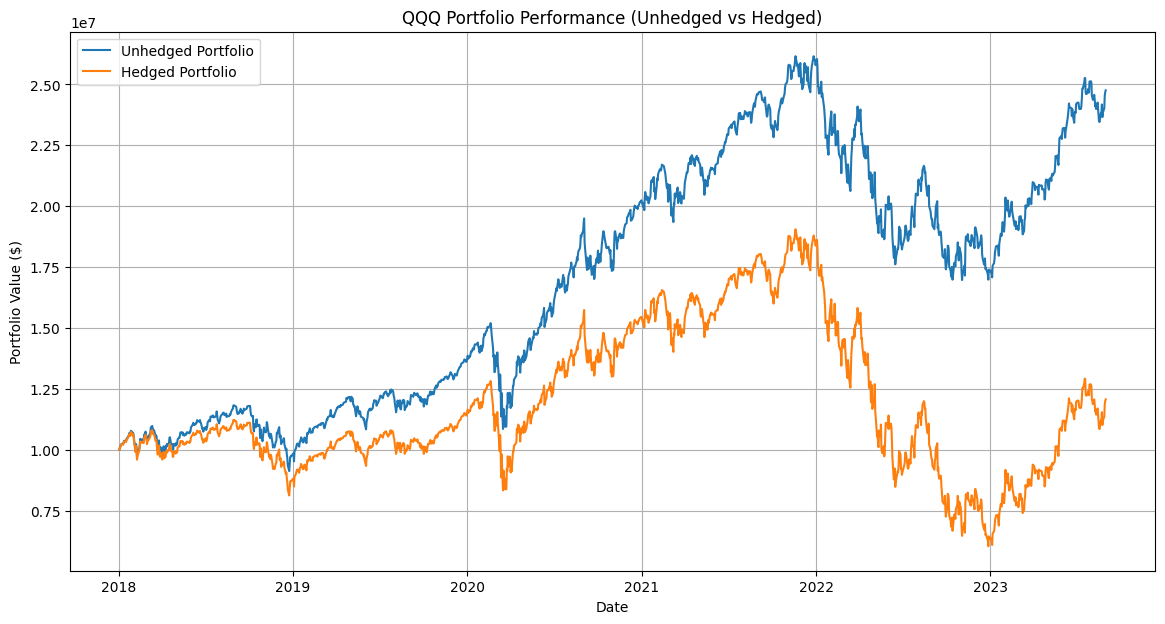

In [ ]:
# ===============================================
# After atm_pivot is created
# ===============================================

# Step 1: Merge QQQ daily with atm_pivot
portfolio = qqq_daily.merge(atm_pivot, left_on='Date', right_on='date', how='inner')

# Step 2: Set initial portfolio settings
initial_investment = 10_000_000  # $10M
start_price = portfolio['Close'].iloc[0]
num_shares = initial_investment / start_price

# Calculate daily portfolio value
portfolio['Portfolio_Value'] = num_shares * portfolio['Close']

# Portfolio delta = number of shares (stock has delta ≈ +1)
portfolio['Portfolio_Delta'] = num_shares

# Calculate daily PnL
portfolio['Portfolio_PnL'] = portfolio['Portfolio_Value'].diff().fillna(0)

# Step 3: Set up hedge tracking
tolerance_band = 10_000  # Example: ±10,000 delta tolerance
hedge_actions = []
current_hedge_positions = []
current_hedge_delta = 0

# Step 4: Loop through each day
for idx, row in portfolio.iterrows():
    portfolio_delta = row['Portfolio_Delta']
    net_delta = portfolio_delta - current_hedge_delta
    action = 'No hedge'
    contracts_to_trade = 0
    option_used = None

    # Expire old hedges if option expired
    still_valid_hedges = []
    for hedge in current_hedge_positions:
        if row['date'] < hedge['expiration']:
            still_valid_hedges.append(hedge)
        else:
            # Hedge expired --> remove delta
            current_hedge_delta -= hedge['contracts'] * hedge['option_delta'] * 100
    current_hedge_positions = still_valid_hedges

    # Check if need to hedge
    if abs(net_delta) > tolerance_band:
        if net_delta > 0:
            # Too positive --> Buy Puts
            option_delta = row['P_delta_option']
            if abs(option_delta) > 1e-6:
                contracts_to_trade = round(net_delta / (option_delta * 100))
                current_hedge_delta += contracts_to_trade * option_delta * 100
                action = f"BUY {contracts_to_trade} puts"
                option_used = 'put'
                current_hedge_positions.append({
                    'contracts': contracts_to_trade,
                    'option_delta': option_delta,
                    'expiration': row['P_expiration'],
                    'strike': row['P_strike'],
                    'price': row['P_best_bid']
                })
        else:
            # Too negative --> Sell Calls
            option_delta = row['C_delta_option']
            if abs(option_delta) > 1e-6:
                contracts_to_trade = round(net_delta / (option_delta * 100))
                current_hedge_delta += contracts_to_trade * option_delta * 100
                action = f"SELL {contracts_to_trade} calls"
                option_used = 'call'
                current_hedge_positions.append({
                    'contracts': contracts_to_trade,
                    'option_delta': option_delta,
                    'expiration': row['C_expiration'],
                    'strike': row['C_strike'],
                    'price': row['C_best_bid']
                })

    hedge_actions.append({
        'Date': row['date'],
        'Portfolio_Delta': portfolio_delta,
        'Current_Hedge_Delta': current_hedge_delta,
        'Net_Delta': portfolio_delta - current_hedge_delta,
        'Action': action,
        'Contracts_Traded': contracts_to_trade,
        'Option_Used': option_used,
    })

# Step 5: Convert the hedge actions into a DataFrame
hedge_actions_df = pd.DataFrame(hedge_actions)

# Step 6: Calculate daily hedge PnL
hedge_pnl_list = []
active_hedges = []

for idx, row in portfolio.iterrows():
    daily_hedge_pnl = 0

    # New hedges added today?
    new_hedges_today = hedge_actions_df[
        (hedge_actions_df['Date'] == row['date']) & (hedge_actions_df['Action'] != 'No hedge')
    ]
    for _, hedge_row in new_hedges_today.iterrows():
        hedge = {
            'option_used': hedge_row['Option_Used'],
            'contracts': hedge_row['Contracts_Traded'],
            'price': row['P_best_bid'] if hedge_row['Option_Used'] == 'put' else row['C_best_bid'],
            'expiration': row['P_expiration'] if hedge_row['Option_Used'] == 'put' else row['C_expiration']
        }
        active_hedges.append(hedge)

    # Calculate today's hedge pnl
    still_active = []
    for hedge in active_hedges:
        if row['date'] <= hedge['expiration']:
            daily_hedge_pnl += hedge['contracts'] * hedge['price']
            still_active.append(hedge)

    active_hedges = still_active
    hedge_pnl_list.append(daily_hedge_pnl)

# Step 7: Final Net PnL
portfolio['Hedge_PnL'] = hedge_pnl_list
portfolio['Net_PnL'] = portfolio['Portfolio_PnL'] + portfolio['Hedge_PnL']

# Step 8: Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

# Unhedged Portfolio
plt.plot(
    portfolio['Date'],
    initial_investment + portfolio['Portfolio_PnL'].cumsum(),
    label='Unhedged Portfolio'
)

# Hedged Portfolio
plt.plot(
    portfolio['Date'],
    initial_investment + portfolio['Net_PnL'].cumsum(),
    label='Hedged Portfolio'
)

plt.title('QQQ Portfolio Performance (Unhedged vs Hedged)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()



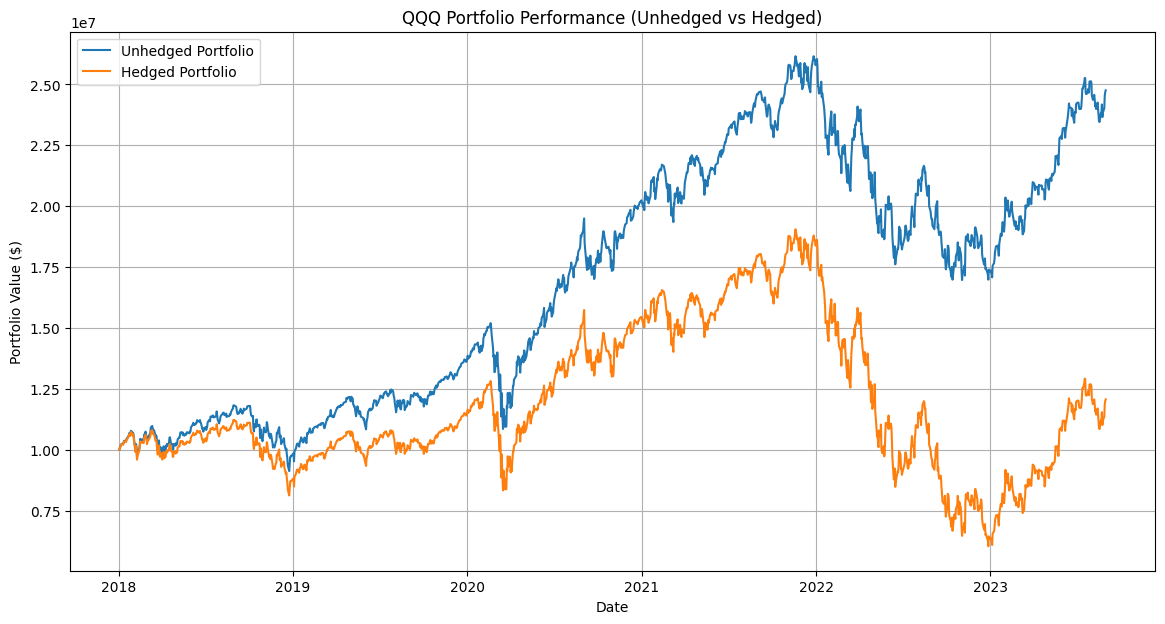

=== Unhedged Portfolio ===
Annualized Return: 17.37%
Annualized Volatility: 25.43%
Sharpe Ratio: 0.68
Max Drawdown: -35.12%

=== Hedged Portfolio ===
Annualized Return: 3.39%
Annualized Volatility: 39.54%
Sharpe Ratio: 0.09
Max Drawdown: -68.26%


In [ ]:
# Step 8: Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

# Unhedged Portfolio
plt.plot(
    portfolio['Date'],
    initial_investment + portfolio['Portfolio_PnL'].cumsum(),
    label='Unhedged Portfolio'
)

# Hedged Portfolio
plt.plot(
    portfolio['Date'],
    initial_investment + portfolio['Net_PnL'].cumsum(),
    label='Hedged Portfolio'
)

plt.title('QQQ Portfolio Performance (Unhedged vs Hedged)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


# Step 1: Cumulative Value
portfolio['Unhedged_Value'] = initial_investment + portfolio['Portfolio_PnL'].cumsum()
portfolio['Hedged_Value'] = initial_investment + portfolio['Net_PnL'].cumsum()

# Step 2: Calculate daily returns properly (pct change)
portfolio['Unhedged_Return'] = portfolio['Unhedged_Value'].pct_change().fillna(0)
portfolio['Hedged_Return'] = portfolio['Hedged_Value'].pct_change().fillna(0)

# Step 3: Define a function for metrics
def calculate_metrics(returns, cumulative_value):
    annualized_return = (cumulative_value.iloc[-1] / cumulative_value.iloc[0]) ** (252/len(returns)) - 1
    annualized_volatility = np.std(returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    cumulative_max = cumulative_value.cummax()
    drawdown = (cumulative_value - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    return annualized_return, annualized_volatility, sharpe_ratio, max_drawdown

# Step 4: Calculate metrics
unhedged_metrics = calculate_metrics(portfolio['Unhedged_Return'], portfolio['Unhedged_Value'])
hedged_metrics = calculate_metrics(portfolio['Hedged_Return'], portfolio['Hedged_Value'])

# Step 5: Print results
print("=== Unhedged Portfolio ===")
print(f"Annualized Return: {unhedged_metrics[0]:.2%}")
print(f"Annualized Volatility: {unhedged_metrics[1]:.2%}")
print(f"Sharpe Ratio: {unhedged_metrics[2]:.2f}")
print(f"Max Drawdown: {unhedged_metrics[3]:.2%}")
print()
print("=== Hedged Portfolio ===")
print(f"Annualized Return: {hedged_metrics[0]:.2%}")
print(f"Annualized Volatility: {hedged_metrics[1]:.2%}")
print(f"Sharpe Ratio: {hedged_metrics[2]:.2f}")
print(f"Max Drawdown: {hedged_metrics[3]:.2%}")



## try 2

In [17]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import norm


# Helper: Black-Scholes formula
def bs_price(S, K, T, r, sigma, option_type='call'):
    if T <= 0:
        return max(S - K, 0) if option_type == 'call' else max(K - S, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
# Classify volatility regimes
def classify_regime(vxn_value):
    if vxn_value < 20:
        return 'Low'
    elif 20 <= vxn_value <= 30:
        return 'Moderate'
    else:
        return 'High'


# Load your data
options_data = pd.read_csv('Data/qqq_option_data_2018_2023.csv')  # Replace path if needed
options_data['date'] = pd.to_datetime(options_data['date'])
options_data['strike_price'] = options_data['strike_price']/1000


qqq_daily = yf.download('QQQ', start='2018-01-01', end='2023-12-31', interval='1d').reset_index()
vxn_daily = yf.download('^VXN', start='2018-01-01', end='2023-12-31', interval='1d').reset_index()

# flatten
if isinstance(vxn_daily.columns, pd.MultiIndex):
    vxn_daily.columns = vxn_daily.columns.get_level_values(0)  # Drop the 'Ticker' second level
vxn_daily = vxn_daily.reset_index()
if isinstance(qqq_daily.columns, pd.MultiIndex):
    qqq_daily.columns = qqq_daily.columns.get_level_values(0)  # Drop the 'Ticker' second level
qqq_daily = qqq_daily.reset_index()
qqq_daily = qqq_daily.rename(columns={'Close': 'QQQ_Close'})
vxn_daily['Regime'] = vxn_daily['Close'].apply(classify_regime)
qqq_daily = qqq_daily.merge(vxn_daily[['Date', 'Regime']], on='Date', how='left')


options_data = options_data.merge(qqq_daily[['Date', 'QQQ_Close']], left_on='date', right_on='Date', how='left')
options_data['moneyness'] = abs(options_data['strike_price'] - options_data['QQQ_Close'])
options_data.rename(columns={
    'strike_price': 'strike',
    'cp_flag': 'type',
    'exdate': 'expiration_date_option',  # <== THIS IS IMPORTANT
}, inplace=True)

print(options_data.columns)
options_data.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Index(['date', 'expiration_date_option', 'type', 'strike', 'delta', 'gamma',
       'impl_volatility', 'best_bid', 'best_offer', 'volume', 'open_interest',
       'optionid', 'secid', 'Date', 'QQQ_Close', 'moneyness'],
      dtype='object')


,date,expiration_date_option,type,strike,delta,gamma,impl_volatility,best_bid,best_offer,volume,open_interest,optionid,secid,Date,QQQ_Close,moneyness
0,2018-01-02,2018-02-02,C,148.5,0.892498,0.021384,0.186879,10.49,10.70,4.0,40.0,118524041.0,107899.0,2018-01-02,150.949265,2.449265
1,2018-01-02,2018-02-02,C,149.5,0.875178,0.024551,0.181047,9.61,9.73,2.0,12.0,118524043.0,107899.0,2018-01-02,150.949265,1.449265
2,2018-01-02,2018-02-02,C,153.0,0.791621,0.039376,0.157560,6.48,6.56,3.0,42.0,118524049.0,107899.0,2018-01-02,150.949265,2.050735
3,2018-01-02,2018-02-02,C,153.5,0.776244,0.042127,0.153491,6.05,6.11,11.0,98.0,118524050.0,107899.0,2018-01-02,150.949265,2.550735
4,2018-01-02,2018-02-02,C,154.0,0.758090,0.044900,0.150400,5.63,5.69,20.0,91.0,118524051.0,107899.0,2018-01-02,150.949265,3.050735


In [22]:
# === Setup Parameters ===
rebalance_frequency = 5  # Rebalance every 5 business days
strike_offset_call = 1.03  # 3% OTM call
strike_offset_put_buy = 0.95  # 5% OTM buy put
strike_offset_put_sell = 0.97  # 3% OTM sell put
risk_free_rate = 0.00

# === Initialize Portfolio ===
initial_investment = 10_000_000
stock_quantity = initial_investment / qqq_daily['QQQ_Close'].iloc[0]

portfolio_value = []
cash = 0
active_options = []

# === Helper function to select closest strike ===
def find_closest_option(row, options_df, option_type, strike_target):
    candidates = options_df[
        (options_df['date'] == row['Date']) &
        (options_df['type'] == option_type)
    ].copy()
    if candidates.empty:
        return None
    candidates['strike_diff'] = abs(candidates['strike'] - strike_target)
    return candidates.sort_values('strike_diff').iloc[0]

# === Run the Simulation ===
for i, row in qqq_daily.iterrows():
    S = row['QQQ_Close']

    # === Rebalance Hedge every 5 days ===
    if i % rebalance_frequency == 0:

        # Close all active options: MTM to zero (profit/loss realized already)
        active_options = []

        regime = row['Regime']

        # Select options depending on regime
        if regime == 'Low':
            # Covered Call Strategy
            call_strike = S * strike_offset_call
            call_option = find_closest_option(row, options_data, 'C', call_strike)
            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium  # Sell Call = collect premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,  # -1 because we SOLD the call
                    'implied_vol': call_option['impl_volatility']
                })

        elif regime == 'Moderate':
            # Put Spread Collar
            # Buy 5% OTM Put
            put_buy_strike = S * strike_offset_put_buy
            put_buy_option = find_closest_option(row, options_data, 'P', put_buy_strike)
            # Sell 3% OTM Put
            put_sell_strike = S * strike_offset_put_sell
            put_sell_option = find_closest_option(row, options_data, 'P', put_sell_strike)
            # Sell 3% OTM Call
            call_strike = S * strike_offset_call
            call_option = find_closest_option(row, options_data, 'C', call_strike)

            if put_buy_option is not None:
                premium = put_buy_option['best_offer'] * 100
                cash -= premium  # Buy Put = pay premium
                active_options.append({
                    'type': 'put',
                    'strike': put_buy_option['strike'],
                    'expiration': put_buy_option['expiration_date_option'],
                    'entry_price': put_buy_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,  # 1 because we BOUGHT the put
                    'implied_vol': put_buy_option['impl_volatility']
                })

            if put_sell_option is not None:
                premium = put_sell_option['best_bid'] * 100
                cash += premium  # Sell Put = collect premium
                active_options.append({
                    'type': 'put',
                    'strike': put_sell_option['strike'],
                    'expiration': put_sell_option['expiration_date_option'],
                    'entry_price': put_sell_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,  # -1 because we SOLD the put
                    'implied_vol': put_sell_option['impl_volatility']
                })

            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium  # Sell Call = collect premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,  # -1 because we SOLD the call
                    'implied_vol': call_option['impl_volatility']
                })

        elif regime == 'High':
            # Protective Collar
            # Buy 5% OTM Put
            put_buy_strike = S * strike_offset_put_buy
            put_buy_option = find_closest_option(row, options_data, 'P', put_buy_strike)
            # Sell 3% OTM Call
            call_strike = S * strike_offset_call
            call_option = find_closest_option(row, options_data, 'C', call_strike)

            if put_buy_option is not None:
                premium = put_buy_option['best_offer'] * 100
                cash -= premium  # Buy Put = pay premium
                active_options.append({
                    'type': 'put',
                    'strike': put_buy_option['strike'],
                    'expiration': put_buy_option['expiration_date_option'],
                    'entry_price': put_buy_option['best_offer'],
                    'contracts': stock_quantity / 100,
                    'direction': 1,
                    'implied_vol': put_buy_option['impl_volatility']
                })

            if call_option is not None:
                premium = call_option['best_bid'] * 100
                cash += premium  # Sell Call = collect premium
                active_options.append({
                    'type': 'call',
                    'strike': call_option['strike'],
                    'expiration': call_option['expiration_date_option'],
                    'entry_price': call_option['best_bid'],
                    'contracts': stock_quantity / 100,
                    'direction': -1,
                    'implied_vol': call_option['impl_volatility']
                })

    # === Daily MTM Pricing of Active Options ===
    option_value = 0
    for hedge in active_options:
        expiration_date = pd.to_datetime(hedge['expiration'])  # ✅ Fix type
        T = (expiration_date - row['Date']).days / 365
        if T > 0:
            price = bs_price(S, hedge['strike'], T, risk_free_rate, hedge['implied_vol'], hedge['type'])
        else:
            price = 0
        option_value += hedge['contracts'] * hedge['direction'] * price * 100  # contracts * lot size (100 shares)

    total_value = stock_quantity * S + cash + option_value
    portfolio_value.append(total_value)

# Final Portfolio Data
qqq_daily['Portfolio_Value'] = portfolio_value


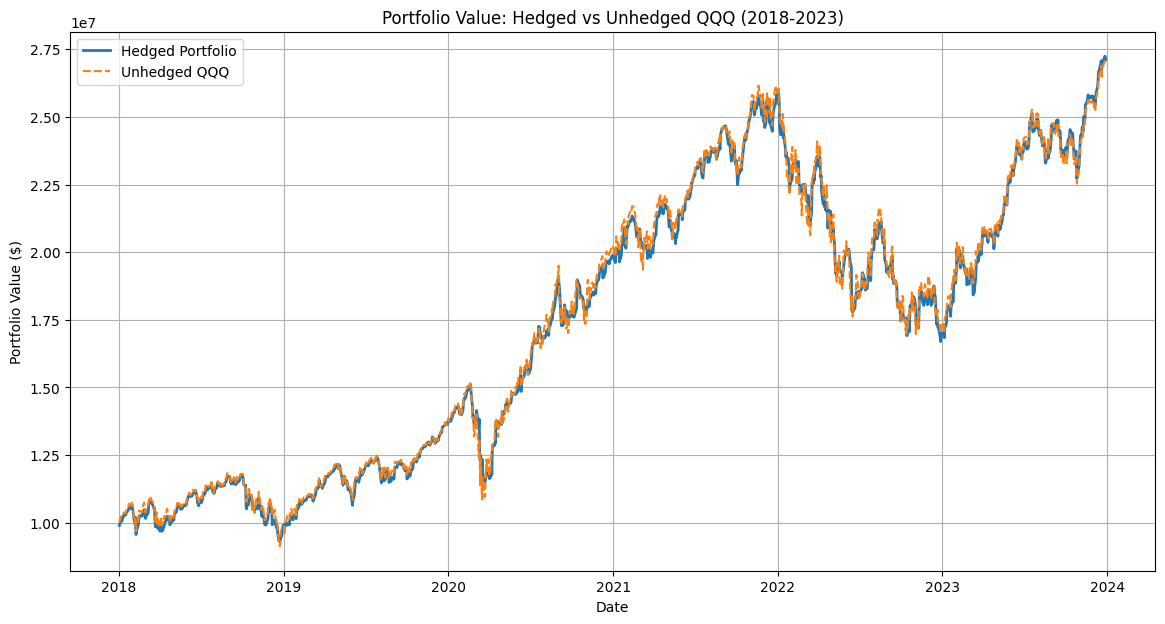

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(qqq_daily['Date'], qqq_daily['Portfolio_Value'], label='Hedged Portfolio', linewidth=2)
plt.plot(qqq_daily['Date'], initial_investment * qqq_daily['QQQ_Close'] / qqq_daily['QQQ_Close'].iloc[0], label='Unhedged QQQ', linestyle='--')
plt.title('Portfolio Value: Hedged vs Unhedged QQQ (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
def calculate_metrics(portfolio_values):
    returns = portfolio_values.pct_change().dropna()
    cumulative_return = portfolio_values.iloc[-1] / portfolio_values.iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(portfolio_values)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    cumulative_max = portfolio_values.cummax()
    drawdown = (portfolio_values - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()
    
    return {
        'Cumulative Return': cumulative_return,
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }

# Calculate for Hedged and Unhedged
hedged_metrics = calculate_metrics(qqq_daily['Portfolio_Value'])
unhedged_values = initial_investment * qqq_daily['QQQ_Close'] / qqq_daily['QQQ_Close'].iloc[0]
unhedged_metrics = calculate_metrics(unhedged_values)

# Display
print("\n=== Hedged Portfolio Metrics ===")
for k, v in hedged_metrics.items():
    print(f"{k}: {v:.2%}")

print("\n=== Unhedged QQQ Metrics ===")
for k, v in unhedged_metrics.items():
    print(f"{k}: {v:.2%}")



=== Hedged Portfolio Metrics ===
Cumulative Return: 173.89%
Annualized Return: 18.32%
Annualized Volatility: 20.17%
Sharpe Ratio: 90.84%
Max Drawdown: -35.48%

=== Unhedged QQQ Metrics ===
Cumulative Return: 169.29%
Annualized Return: 17.99%
Annualized Volatility: 25.00%
Sharpe Ratio: 71.95%
Max Drawdown: -35.12%


# notes

In [ ]:
# Define volatility regimes
def get_regime(vxn_level):
    if vxn_level < 20: return 'Low'
    elif 20 <= vxn_level <= 30: return 'Moderate'
    else: return 'High'

# Strategy rules
def select_strategy(regime):
    strategies = {
        'Low': {'type': 'Covered Call', 'put_strike': 0.97, 'call_strike': 1.03},
        'Moderate': {'type': 'Put Spread Collar', 'put_strike': 0.95, 'short_put': 0.90, 'call_strike': 1.05},
        'High': {'type': 'Protective Collar', 'put_strike': 0.90, 'call_strike': 1.02}
    }
    return strategies[regime]

initial_capital = 100000

In [ ]:
# Strategy rules
def select_strategy(regime):
    strategies = {
        'Low': {'type': 'Covered Call', 'put_strike': 0.97, 'call_strike': 1.03},
        'Moderate': {'type': 'Put Spread Collar', 'put_strike': 0.95, 'short_put': 0.90, 'call_strike': 1.05},
        'High': {'type': 'Protective Collar', 'put_strike': 0.90, 'call_strike': 1.02}
    }
    return strategies[regime]

# Backtest parameters
initial_capital = 100000
transaction_cost = 0.001  # 0.1% per trade

# Initialize portfolio
portfolio = pd.DataFrame(index=qqq.index)
portfolio['QQQ_Price'] = qqq
portfolio['VXN'] = vxn
portfolio['Regime'] = portfolio['VXN'].apply(get_regime)
portfolio['Strategy'] = portfolio['Regime'].apply(select_strategy)

# Simulate hedging effectiveness
hedge_effectiveness = {
    'Low': {'downside_capture': 0.85, 'upside_capture': 0.92, 'cost': 0.002},
    'Moderate': {'downside_capture': 0.65, 'upside_capture': 0.80, 'cost': 0.005},
    'High': {'downside_capture': 0.50, 'upside_capture': 0.70, 'cost': 0.008}
}

# Calculate returns
portfolio['QQQ_Return'] = portfolio['QQQ_Price'].pct_change()
portfolio['Hedged_Return'] = portfolio.apply(
    lambda row: row['QQQ_Return'] * hedge_effectiveness[row['Regime']]['upside_capture'] 
    if row['QQQ_Return'] > 0 
    else row['QQQ_Return'] * hedge_effectiveness[row['Regime']]['downside_capture'], 
    axis=1
)

# Account for costs
portfolio['Transaction_Cost'] = portfolio['Strategy'].apply(lambda x: hedge_effectiveness[x['Regime']]['cost'])
portfolio['Net_Return'] = portfolio['Hedged_Return'] - portfolio['Transaction_Cost']

# Calculate cumulative returns
portfolio['QQQ_Value'] = initial_capital * (1 + portfolio['QQQ_Return']).cumprod()
portfolio['Hedged_Value'] = initial_capital * (1 + portfolio['Net_Return']).cumprod()

# Plot results
plt.figure(figsize=(14,7))
plt.plot(portfolio['QQQ_Value'], label='Unhedged QQQ')
plt.plot(portfolio['Hedged_Value'], label='VXN-Regime Hedged Portfolio')
plt.title('QQQ Hedging Strategy Performance (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Performance metrics
def calculate_metrics(returns):
    total_return = returns[-1]/returns[0] - 1
    annualized_return = (1 + total_return)**(252/len(returns)) - 1
    max_drawdown = (returns.cummax() - returns).max()
    sharpe_ratio = np.sqrt(252) * returns.mean() / returns.std()
    return annualized_return, max_drawdown, sharpe_ratio

qqq_metrics = calculate_metrics(portfolio['QQQ_Value'])
hedged_metrics = calculate_metrics(portfolio['Hedged_Value'])

NameError: name 'qqq' is not defined

In [ ]:
class QQQHedger:
    def __init__(self):
        self.vol_model = HybridVolatilityForecaster()
        self.hedge_engine = DynamicHedgeOptimizer()
    
    def execute_strategy(self, price_data):
        # Volatility regime detection
        regime = self.vol_model.detect_regime(price_data)
        
        # Core hedge adjustment
        if regime == 'Normal':
            self.hedge_engine.apply_put_spread()
        elif regime == 'Elevated':
            self.hedge_engine.apply_collar()
        else:
            self.hedge_engine.apply_crisis_hedge()
            
        # Gamma scalping execution
        self.hedge_engine.gamma_rebalance()
        
        # Transaction cost optimization
        self.hedge_engine.optimize_trade_size()
